In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [2]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'Train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}



In [3]:
data_dir = r"C:\Users\Rekha\Documents\pytorch_image_classification"
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
  chosen_transforms[x])
                  for x in ['Train', 'Test']}

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=4)
              for x in ['Train', 'Test']}

In [5]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['Train', 'Test']}
class_names = chosen_datasets['Train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

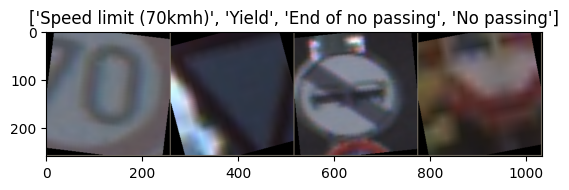

In [7]:
inputs, classes = next(iter(dataloaders['Train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [11]:
#Setting up a Pretrained Model

In [12]:
# Setting up the model
# load in pretrained and reset final fully connected

#res_mod = models.resnet34(pretrained=True)

#num_ftrs = res_mod.fc.in_features
#number_of_classes =43
#res_mod.fc = nn.Linear(num_ftrs, number_of_classes)

In [13]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [14]:
#res_mod = res_mod.to(device)
#criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
res_mod = models.resnet34(pretrained=True)
for param in res_mod.parameters():
    param.requires_grad = False

num_ftrs = res_mod.fc.in_features
number_of_classes =43
res_mod.fc = nn.Linear(num_ftrs, number_of_classes)

res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Here's another change: instead of all parameters being optimized
# only the params of the final layers are being optimized

optimizer_ft = optim.SGD(res_mod.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
for name, child in res_mod.named_children():
    if name in ['layer3', 'layer4']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer3has been unfrozen.
layer4has been unfrozen.


In [9]:
optimizer_conv = torch.optim.SGD(filter(lambda x: x.requires_grad, res_mod.parameters()), lr=0.001, momentum=0.9)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#res_mod = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [11]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
Iterating through data...


C:\Users\Rekha\anaconda3\envs\detectron_env\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 3.9736 Acc: 0.0178
Iterating through data...
Test Loss: 3.9892 Acc: 0.0137

Epoch 1/24
----------
Iterating through data...


KeyboardInterrupt: 

In [16]:
#Visualization

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(base_model)
plt.show()